## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

the dataset is: detector with several channels which measure time (time to digital converter)
we have 2 FPGA, each has many channels (address), the measurement is in 25/30 nanoseconds, when meas is 30 it increases the counter, also when the counter reaches the max (to find!) it increases orbit counter

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import numpy as np
import pandas as pd

In [9]:
file_name="data/data_000637.txt"
N=11e6
data=pd.read_csv(file_name, nrows=N)
data.tail(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1310710,1,1,36,3869211171,427,13
1310711,1,1,39,3869211171,430,0
1310712,1,1,35,3869211171,429,4
1310713,1,0,64,3869211171,758,18
1310714,1,0,60,3869211171,762,2
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0
1310719,1,0,61,3869211171,762,18


In [10]:
data.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1310720.0,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06
mean,1.0,2.959198e-01,5.582570e+01,3.869206e+09,1.781096e+03,1.332340e+01
std,0.0,4.564553e-01,3.901034e+01,3.183124e+03,1.027795e+03,9.199886e+00
min,1.0,0.000000e+00,1.000000e+00,3.869200e+09,0.000000e+00,0.000000e+00
25%,1.0,0.000000e+00,2.600000e+01,3.869203e+09,8.930000e+02,5.000000e+00
50%,1.0,0.000000e+00,5.700000e+01,3.869207e+09,1.778000e+03,1.300000e+01
75%,1.0,1.000000e+00,6.400000e+01,3.869209e+09,2.670000e+03,2.100000e+01
max,1.0,1.000000e+00,1.390000e+02,3.869211e+09,3.563000e+03,2.900000e+01


when TDC_MEAS=30 -> BX_COUNTER += 1 and TDC_MEAS=0,
when BX_COUNTER=3564 -> ORBIT_CNT +=1 and BX_COUNTER=0

In [11]:
data.sort_values(by=['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS'], ascending=False)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1310718,1,0,139,3869211171,769,0
1310717,1,0,64,3869211171,764,0
1310716,1,1,4,3869211171,763,11
1310719,1,0,61,3869211171,762,18
1310715,1,0,62,3869211171,762,14
...,...,...,...,...,...,...
4,1,0,64,3869200167,2760,25
3,1,0,64,3869200167,2558,19
2,1,0,63,3869200167,2553,28
1,1,0,124,3869200167,2374,27


to calculate the exact time in ns: `TDC_MEAS*25/30+BX_COUNTER*25+ORBIT_CNT*3564*25`
last measurement is index 1310718, while first measurement is 0

In [12]:
print(data.iloc[0,3:6])
print(data.iloc[1310718,3:6])

b=data.iloc[0,5]*25/30+data.iloc[0,4]*25+data.iloc[0,3]*25*3564
e=data.iloc[1310718,5]*25/30+data.iloc[1310718,4]*25+data.iloc[1310718,3]*25*3564
tot_time=e-b

print(tot_time/10**9, 's')

ORBIT_CNT     3869200167
BX_COUNTER          2374
TDC_MEAS              26
Name: 0, dtype: int64
ORBIT_CNT     3869211171
BX_COUNTER           769
TDC_MEAS               0
Name: 1310718, dtype: int64
0.9804162533125 s


In [13]:
data['time'] = pd.Series(data["TDC_MEAS"]*25/30+data["BX_COUNTER"]*25+data["ORBIT_CNT"]*3564*25, index=data.index)   #apply a function to a column to define a new column
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


In [14]:
data.loc[:,'HEAD'] = np.random.randint(0,2, len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,0,0,123,3869200167,2374,26,3.447457e+14
1,0,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,0,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


In [15]:
data1=data[data['HEAD']==1]
data1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
...,...,...,...,...,...,...,...
1310709,1,1,38,3869211171,417,8,3.447467e+14
1310714,1,0,60,3869211171,762,2,3.447467e+14
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

<Figure size 640x480 with 0 Axes>

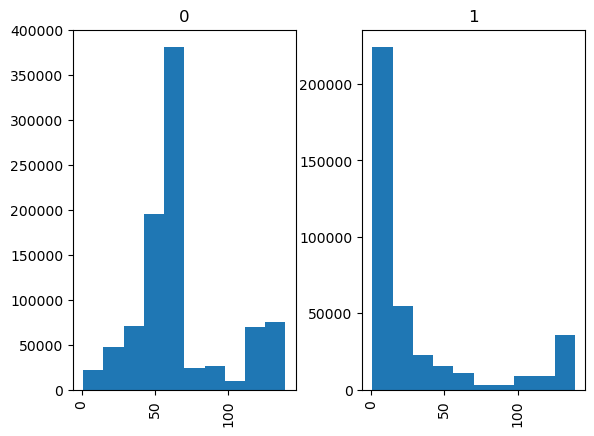

In [18]:
from matplotlib import pyplot as plt
plt.figure()
data.hist('TDC_CHANNEL', by='FPGA')

In [30]:
data['Count']=np.array([1]*len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time,Count
0,0,0,123,3869200167,2374,26,3.447457e+14,1
1,0,0,124,3869200167,2374,27,3.447457e+14,1
2,1,0,63,3869200167,2553,28,3.447457e+14,1
3,1,0,64,3869200167,2558,19,3.447457e+14,1
4,0,0,64,3869200167,2760,25,3.447457e+14,1
...,...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14,1
1310716,0,1,4,3869211171,763,11,3.447467e+14,1
1310717,1,0,64,3869211171,764,0,3.447467e+14,1
1310718,1,0,139,3869211171,769,0,3.447467e+14,1


In [32]:
result = data.loc[:,['TDC_CHANNEL','Count']].groupby('TDC_CHANNEL').sum()
print(result.sort_values(by='Count', ascending=False))

              Count
TDC_CHANNEL        
139          108059
64            66020
63            64642
61            49479
62            49349
...             ...
126             606
130              71
138              70
137              68
129              37

[133 rows x 1 columns]


In [37]:
data.loc[:,['ORBIT_CNT','Count']].groupby('ORBIT_CNT').sum().sort_values(by='Count')

,Count
ORBIT_CNT,
3869206180,1
3869204142,1
3869203571,2
3869205800,2
3869205342,3
...,...
3869206506,305
3869206967,322
3869209661,324


In [46]:
data[data['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count().sort_values(by='Count').loc[:,['Count']]

,Count
ORBIT_CNT,
3869204060,1
3869204762,1
3869204217,1
3869206396,1
3869205573,1
...,...
3869206506,25
3869207714,25
3869207812,25
